Imports et installation des packages nécessaires

In [22]:
import sys
# Installer les packages nécessaires dans l'environnement du notebook
!{sys.executable} -m pip install matplotlib seaborn numpy opencv-python scikit-learn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import os
import glob
from collections import Counter, defaultdict
import cv2
from sklearn.cluster import KMeans

print("✅ Librairies chargées !")

✅ Librairies chargées !


 Définir le dataset et les styles (reprise de l'étape 1)

In [23]:
# %%
# Liste des styles disponibles
STYLES = ['boheme', 'industriel', 'minimaliste', 'moderne', 'royal', 'rustique', 'vintage']

# Chemin vers le dataset (à adapter selon ton projet)
DATASET_PATH = Path('../dataset')  # exemple
if not DATASET_PATH.exists():
    print("❌ Dataset non trouvé. Vérifie le chemin DATASET_PATH.")
else:
    print(f"✅ Dataset trouvé : {DATASET_PATH}")

# Créer WORKING_INFO (nombre d'images et chemins)
WORKING_INFO = defaultdict(lambda: {'count':0, 'images':[]})
for style in STYLES:
    style_path = DATASET_PATH / style
    if not style_path.exists():
        continue
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        images.extend(glob.glob(str(style_path / ext)))
    WORKING_INFO[style]['count'] = len(images)
    WORKING_INFO[style]['images'] = images

print("✅ WORKING_INFO configuré pour chaque style.")


✅ Dataset trouvé : ..\dataset
✅ WORKING_INFO configuré pour chaque style.


 Fonction d'extraction rapide des couleurs dominantes

In [24]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def extract_dominant_colors_fast(image_path: str, num_colors: int = 5, resize_dim: int = 100) -> dict:
    """
    Extrait les couleurs dominantes d'une image rapidement.
    """
    try:
        if not os.path.exists(image_path):
            return {'success': False, 'error': f"Fichier introuvable : {image_path}"}
        image = cv2.imread(image_path)
        if image is None:
            return {'success': False, 'error': f"Impossible de charger : {image_path}"}
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (resize_dim, resize_dim), interpolation=cv2.INTER_AREA)
        pixels = image.reshape(-1, 3).astype(np.float32)
        kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=5, max_iter=200)
        kmeans.fit(pixels)
        colors_rgb = kmeans.cluster_centers_.astype(int)
        labels = kmeans.labels_
        total_pixels = len(labels)
        label_counts = Counter(labels)
        sorted_data = []
        for i in range(num_colors):
            count = label_counts[i]
            percentage = (count / total_pixels) * 100
            rgb = tuple(colors_rgb[i])
            hex_color = rgb_to_hex(rgb)
            sorted_data.append({'rgb': rgb, 'hex': hex_color, 'percentage': percentage})
        sorted_data.sort(key=lambda x: x['percentage'], reverse=True)
        return {
            'success': True,
            'colors': [item['hex'] for item in sorted_data],
            'percentages': [round(item['percentage'], 2) for item in sorted_data],
            'rgb_colors': [item['rgb'] for item in sorted_data],
            'image_path': image_path,
            'original_image': image
        }
    except Exception as e:
        return {'success': False, 'error': f"Erreur : {str(e)}"}

print("✅ Fonction extract_dominant_colors_fast prête à l'emploi.")

✅ Fonction extract_dominant_colors_fast prête à l'emploi.


 Visualiser une image et sa palette

In [25]:
def visualize_color_palette(image_path: str, resize_dim: int = 100, figsize=(12,4)):
    """
    Affiche l'image originale et sa palette de couleurs dominantes avec pourcentages.
    """
    result = extract_dominant_colors_fast(image_path, resize_dim=resize_dim)
    if not result['success']:
        print(f"❌ Erreur : {result['error']}")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Image originale
    axes[0].imshow(result['original_image'])
    axes[0].axis('off')
    axes[0].set_title(f"Image : {Path(image_path).name}", fontsize=12, fontweight='bold')
    
    # Palette
    palette = np.zeros((100, 500, 3), dtype=np.uint8)
    x_start = 0
    for rgb, pct in zip(result['rgb_colors'], result['percentages']):
        x_end = x_start + int(500 * pct / 100)
        palette[:, x_start:x_end] = rgb
        x_start = x_end
    axes[1].imshow(palette)
    axes[1].axis('off')
    axes[1].set_title("Palette dominante", fontsize=12, fontweight='bold')
    
    # Texte avec pourcentages
    info_text = "   ".join([f"{color} ({pct:.1f}%)" 
                            for color, pct in zip(result['colors'], result['percentages'])])
    fig.text(0.5, 0.02, info_text, ha='center', fontsize=10, family='monospace')
    
    plt.tight_layout()
    plt.show()

 Visualiser plusieurs images d'un style

In [26]:
def visualize_style_gallery(style_name: str, num_images: int = 5, resize_dim: int = 100):
    if style_name not in STYLES or WORKING_INFO[style_name]['count'] == 0:
        print(f"❌ Style '{style_name}' non disponible")
        return
    
    images = WORKING_INFO[style_name]['images'][:num_images]
    
    # Créer les axes
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 4*num_images))
    
    # Si axes est 1D (num_images=1), on le transforme en 2D pour uniformité
    if num_images == 1:
        axes = np.expand_dims(axes, axis=0)  # shape (1, 2)
    
    for i, img_path in enumerate(images):
        result = extract_dominant_colors_fast(img_path, resize_dim=resize_dim)
        if not result['success']:
            print(f"❌ {img_path} : {result['error']}")
            continue
        
        # Image originale
        axes[i,0].imshow(result['original_image'])
        axes[i,0].axis('off')
        axes[i,0].set_title(f"{Path(img_path).name}", fontsize=10)
        
        # Palette
        palette = np.zeros((100, 500, 3), dtype=np.uint8)
        x_start = 0
        for rgb, pct in zip(result['rgb_colors'], result['percentages']):
            x_end = x_start + int(500 * pct / 100)
            palette[:, x_start:x_end] = rgb
            x_start = x_end
        axes[i,1].imshow(palette)
        axes[i,1].axis('off')
        axes[i,1].set_title("Palette", fontsize=10)
    
    plt.tight_layout()
    plt.show()


Comparer plusieurs styles

In [27]:
def visualize_all_styles_gallery(num_images_per_style: int = 2, resize_dim: int = 100):
    """
    Crée une galerie comparative pour plusieurs styles.
    """
    for style in STYLES:
        if WORKING_INFO[style]['count'] == 0:
            continue
        print(f"🎨 Style : {style}")
        visualize_style_gallery(style, num_images=num_images_per_style, resize_dim=resize_dim)


Tests

📂 Style : boheme | Image : 16026.jpg


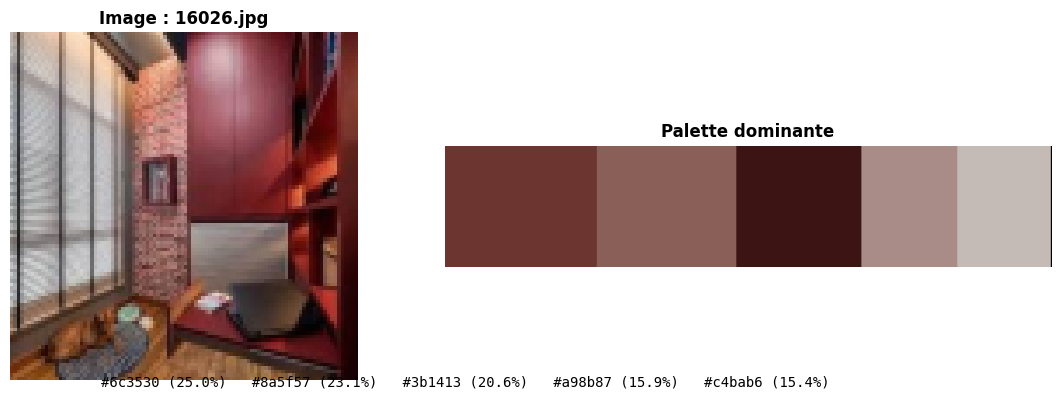

🎨 Galerie pour le style : boheme


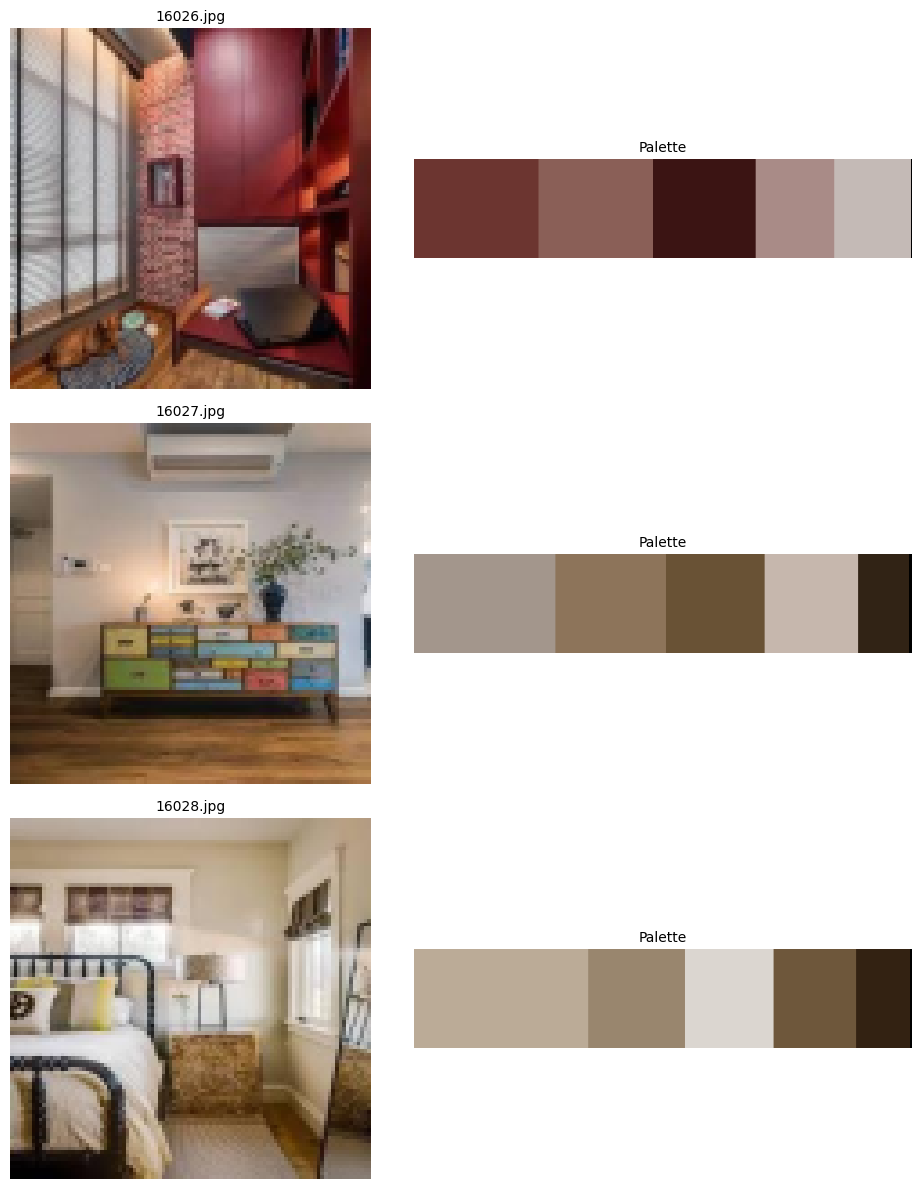

🎨 Style : boheme


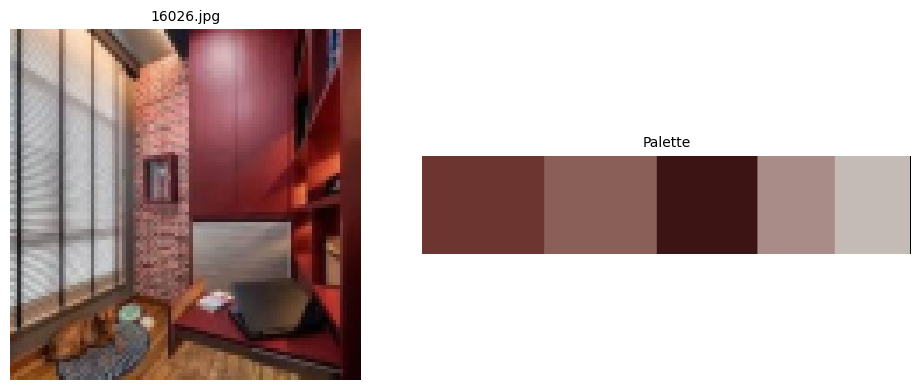

🎨 Style : industriel


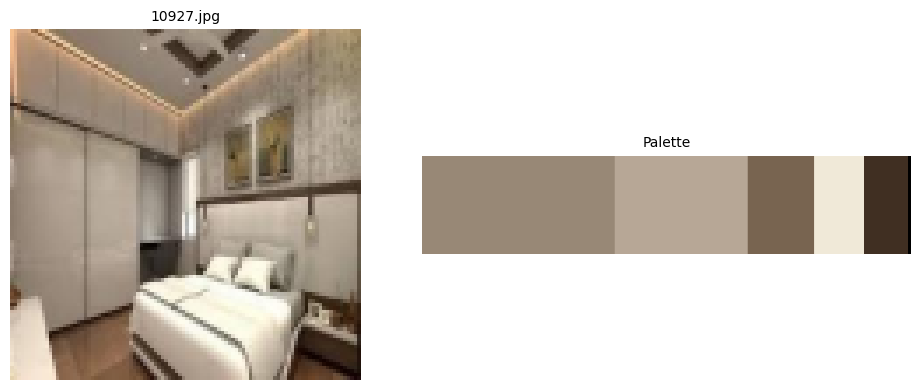

🎨 Style : minimaliste


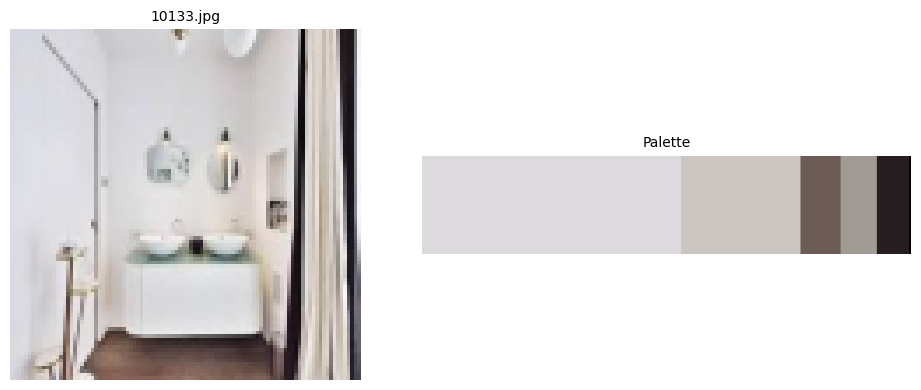

🎨 Style : moderne


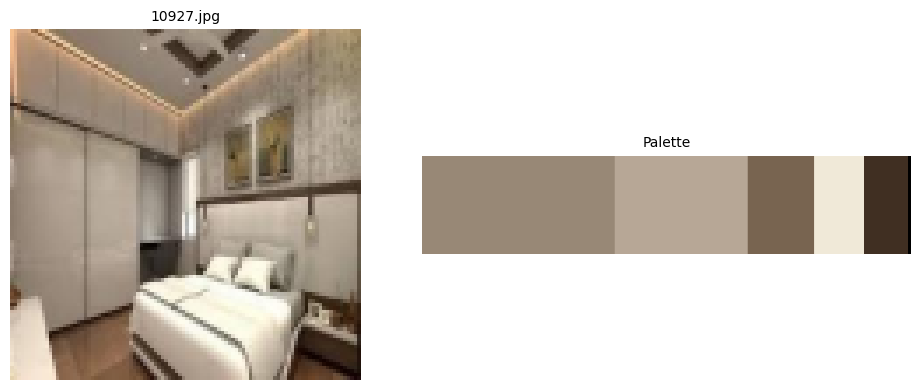

🎨 Style : royal


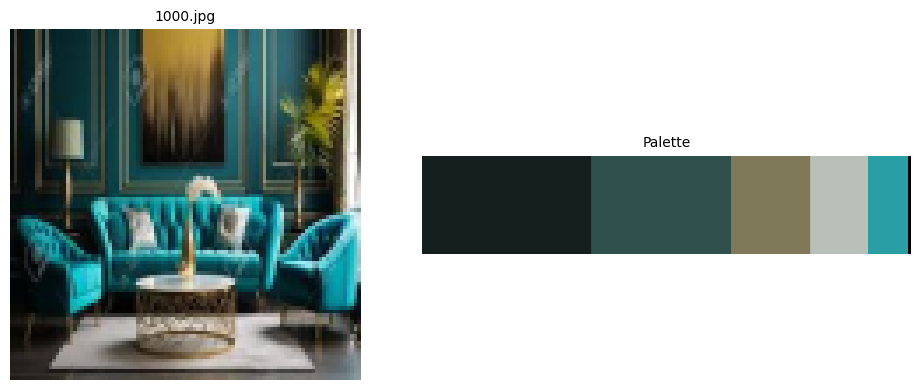

🎨 Style : rustique


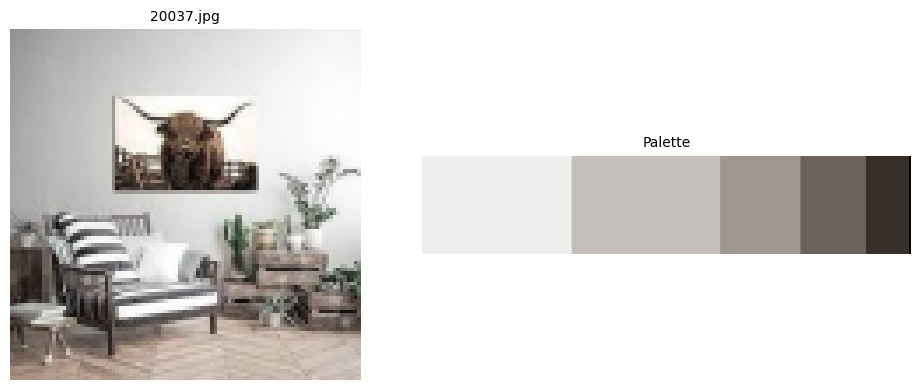

🎨 Style : vintage


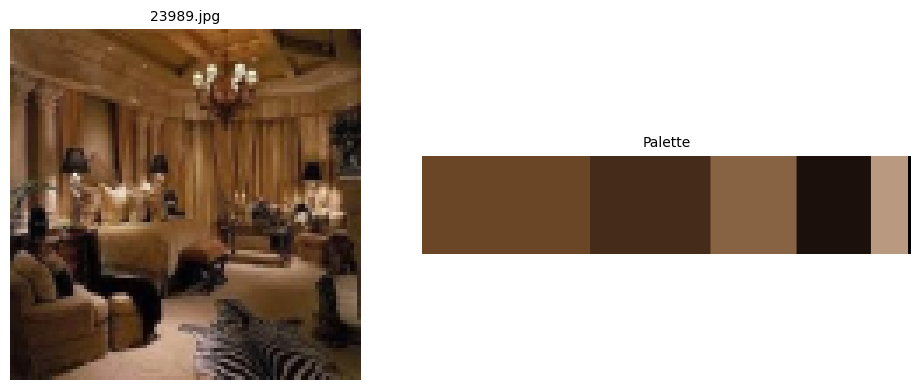

In [28]:
# Test sur la première image disponible
for style in STYLES:
    if WORKING_INFO[style]['count'] > 0:
        test_image = WORKING_INFO[style]['images'][0]
        print(f"📂 Style : {style} | Image : {Path(test_image).name}")
        visualize_color_palette(test_image)
        break

# %%
# Galerie pour un style
for style in STYLES:
    if WORKING_INFO[style]['count'] > 0:
        print(f"🎨 Galerie pour le style : {style}")
        visualize_style_gallery(style, num_images=3)
        break

# %%
# Comparer tous les styles (1 image par style)
visualize_all_styles_gallery(num_images_per_style=1)